### Step 1: Import the Libraries

In [30]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import pandas as pd

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Step 2: Load the Dataset

In [6]:
df=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Train(Stop Words).csv')
df.head(5)


,comment,hate_speech,lemmatized_comment
0,lack of confidence what am i talking about you...,0,lack of confidence what be i talk about you as...
1,it also claims that riot prioritizes core gam...,0,it also claim that riot prioritize core gamers...
2,insert never go full retard clip here,1,insert never go full retard clip here
3,explaining but a man does it so it must be evi...,0,explain but a man do it so it must be evil shi...
4,that is only if you imagine waid is willing to...,0,that be only if you imagine waid be will to bl...


In [7]:
df2=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Test(Stop Words).csv')
df2.head(5)

,comment,hate_speech,lemmatized_comment
0,any fucking person can be an asshole and you’r...,1,any fuck person can be an asshole and you ’ re...
1,yep their bots just auto banning so many peopl...,0,yep their bots just auto ban so many people fr...
2,her friend did tell her and she still decided ...,0,her friend do tell her and she still decide to...
3,i had a thought when some people were being st...,0,i have a think when some people be be stupid a...
4,given he’s a dark skinned guy with a foreign a...,0,give he ’ s a dark skin guy with a foreign acc...


In [8]:
import numpy as np
texts=np.array(df['lemmatized_comment'].tolist())
labels=df['hate_speech'].values

In [9]:
import numpy as np
test_texts=np.array(df2['lemmatized_comment'].tolist())
test_labels=df2['hate_speech'].values

In [10]:
labels


array([0, 0, 1, ..., 0, 0, 0])

In [11]:
test_labels

array([1, 0, 0, ..., 1, 0, 0])

### Step 3: Splitting the Dataset

In [12]:
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

### Step 4: Create a custom dataset class for text classification

This is a custom dataset class that helps organize reddit comments and their sentiments for our BERT model. It takes care of tokenizing the text, handling the sequence length, and providing a neat package with input IDs, attention masks, and labels for our model to learn from.

In [13]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)
        return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'label': torch.tensor(label)}

### Step 5: Build our customer BERT classifier

Our BERT Classifier takes in some input IDs and attention masks, and runs them through BERT and the extra layers we added. The classifier returns our output as class scores.We will then add a dropout layer to keep things in check and a linear layer to help us classify text.

In [14]:
class BERTClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        logits = self.fc(x)
        return logits

### Step 6: Define the train() function

The train() function takes the model, data loader, optimizer, scheduler, and device as its trainees. The function puts the model into training mode and then runs through each batch of data from the data loader. For each batch, it clears the optimizer’s gradients, gets the input IDs, attention masks, and labels, and feeds them to the model.

In [15]:
def train(model, data_loader, optimizer, scheduler, device):
    model.train()
    for batch in data_loader:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = nn.CrossEntropyLoss()(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()

### Step 7: Build our evaluation method

In [16]:
def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())
    return accuracy_score(actual_labels, predictions), classification_report(actual_labels, predictions),confusion_matrix(actual_labels, predictions)

### Step 8: Build our prediction method

The predict_sentiment() function acts as our evaluation method. For each batch, it gets the input IDs, attention masks, and labels and feeds them to the model. The model then gives its best predictions, which are compared to the actual labels.

In [17]:
def predict_sentiment(text, model, tokenizer, device, max_length=128):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
    return "contains hate speech" if preds.item() == 1 else "It is a normal text"

### Step 9: Define our model’s parameters

we are going to set up essential parameters for fine-tuning the BERTClassifier, including the BERT model name, number of classes, maximum input sequence length, batch size, number of training epochs, and learning rate, to help the model effectively understand reddit comments and their sentiments.

In [18]:
# Set up parameters
bert_model_name = 'bert-base-uncased'
num_classes = 2
max_length = 128
batch_size = 16
num_epochs = 10
learning_rate = 2e-5

### Step 10: Initialize tokenizer, dataset, and data loader

In [19]:
tokenizer = BertTokenizer.from_pretrained(bert_model_name)
train_dataset = TextClassificationDataset(train_texts, train_labels, tokenizer, max_length)
test_dataset= TextClassificationDataset(test_texts, test_labels, tokenizer, max_length)
val_dataset = TextClassificationDataset(val_texts, val_labels, tokenizer, max_length)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

### step 11: Loading the Bert Model and setup the device

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BERTClassifier(bert_model_name, num_classes).to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

### Step 12: Set up optimizer and learning rate scheduler

In [21]:
optimizer = AdamW(model.parameters(), lr=learning_rate)
total_steps = len(train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


### Step 13: Training the model

In [23]:
for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        train(model,train_dataloader,optimizer,scheduler,device)
        accuracy, report, matrix = evaluate(model,val_dataloader,device)
        print(f"Validation Accuracy: {accuracy:.4f}")
        print(report)

Epoch 1/10
Validation Accuracy: 0.9106
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      2710
           1       0.82      0.81      0.81       847

    accuracy                           0.91      3557
   macro avg       0.88      0.88      0.88      3557
weighted avg       0.91      0.91      0.91      3557

Epoch 2/10
Validation Accuracy: 0.9100
              precision    recall  f1-score   support

           0       0.94      0.94      0.94      2710
           1       0.81      0.81      0.81       847

    accuracy                           0.91      3557
   macro avg       0.88      0.87      0.88      3557
weighted avg       0.91      0.91      0.91      3557

Epoch 3/10
Validation Accuracy: 0.9092
              precision    recall  f1-score   support

           0       0.93      0.95      0.94      2710
           1       0.82      0.79      0.80       847

    accuracy                           0.91      3557
   macro av

### Step 14: Save the Model

In [24]:
torch.save(model.state_dict(), "bert_classifier.pth")

### Step 15: Evaluating our model’s performance

In [32]:
accuracy, report, matrix = evaluate(model,test_dataloader,device)
print(f"Test Validation Accuracy: {accuracy:.4f}")
print(report)
print(matrix)

Test Validation Accuracy: 0.8950
              precision    recall  f1-score   support

           0       0.93      0.94      0.93      3389
           1       0.79      0.76      0.78      1057

    accuracy                           0.89      4446
   macro avg       0.86      0.85      0.85      4446
weighted avg       0.89      0.89      0.89      4446

[[3171  218]
 [ 249  808]]


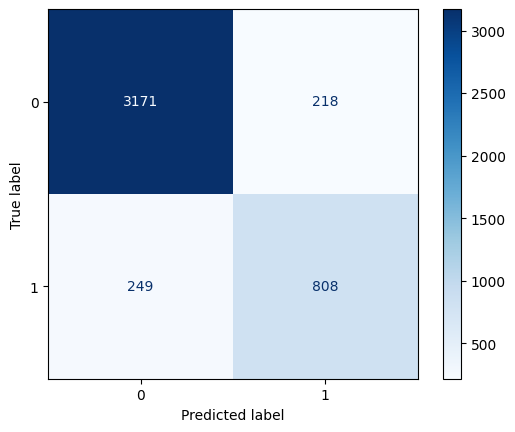

In [38]:
# Plot the confusion matrix
import matplotlib.pyplot as plt
disp = ConfusionMatrixDisplay(confusion_matrix=matrix)
disp.plot(cmap=plt.cm.Blues)
plt.show()

In [27]:
# Test sentiment prediction
test_text = "LMFAOOOO I HATE BLACK PEOPLE https://t.co/RNvD2nLCDR"" This is why there's black people and niggers"
sentiment = predict_sentiment(test_text, model, tokenizer, device)
print(test_text)
print(f"Predicted sentiment: {sentiment}")

LMFAOOOO I HATE BLACK PEOPLE https://t.co/RNvD2nLCDR This is why there's black people and niggers
Predicted sentiment: contains hate speech


In [28]:
# Test sentiment prediction
test_text = "Jackies a retard #blondeproblems"" At least I can make a grilled cheese!"
sentiment = predict_sentiment(test_text, model, tokenizer, device)
print(test_text)
print(f"Predicted sentiment: {sentiment}")

Jackies a retard #blondeproblems At least I can make a grilled cheese!
Predicted sentiment: contains hate speech


In [37]:
 # Test sentiment prediction
test_text = "I like Rick, but only when he is drunk."
sentiment = predict_sentiment(test_text, model, tokenizer, device)
print(test_text)
print(f"Predicted sentiment: {sentiment}")

I like Rick, but only when he is drunk.
Predicted sentiment: It is a normal text
